In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json


def line_decay(max_value, min_value, num_points, decay_rate=3):
    if num_points > 1:
        x = np.linspace(1, 0, num_points)[:-1]
        y = (max_value - min_value) * x + min_value
        zeros = np.zeros(num_points)[:-1]
    else:
        x = np.linspace(1, 0, num_points)
        y = (max_value - min_value) * x + min_value
        zeros = np.zeros(num_points)
    return pd.DataFrame({'oil_pressure_u2': y, 'oil_pump_u2': zeros})

def line_rise(max_value, min_value, num_points, constant_value=1):
    # Generate a linearly increasing sequence
    x = np.linspace(0, 1, num_points)[:-1]
    y = (max_value - min_value) * x + min_value
    z = np.full(num_points, constant_value)[:-1]
    return pd.DataFrame({'oil_pressure_u2': y, 'oil_pump_u2': z})

def generate_data_with_slower_increase(max, min, rise_points, decay_points, initial_recurrence,end_recurrence, repetitions, growth_factor):
    # Generate constant line rise data
    line = line_rise(max, min, rise_points)
    decay = line_decay(max, min, decay_points)

    combined = decay

    # Loop through the repetitions, increasing the line_rise segment proportionally
    for i in range(initial_recurrence):
        # Concatenate decay and the increasing line segment
        combined = pd.concat([combined, line, decay], axis=0, ignore_index=True)

    temp_num_points = rise_points
    # Loop through the repetitions, increasing the line_rise segment proportionally
    for i in range(repetitions):
        line = line_rise(max, min, int(temp_num_points))
        # print(line, '\n', decay ,'-------')
        # Concatenate decay and the increasing line segment
        combined = pd.concat([combined, line, decay], axis=0, ignore_index=True)

        # Increase the number of points for the next line_rise by the growth factor
        temp_num_points *= growth_factor

    for i in range(end_recurrence):
        # Concatenate decay and the increasing line segment
        line = line_rise(max, min, int(rise_points))
        combined = pd.concat([combined, line, decay], axis=0, ignore_index=True)
    
    return combined

def generate_combined_data_with_faster_decay(rise_points, decay_points, initial_recurrence,end_recurrence, repetitions, decay_factor=0.8):
    # Generate constant line rise data
    line = line_rise(max, min, rise_points)
    decay = line_decay(max, min, decay_points)
    
    combined = decay    
    for i in range(initial_recurrence):        
        # Concatenate decay and the constant line segment
        combined = pd.concat([combined, line, decay], axis=0, ignore_index=True)

    # Loop through the repetitions, reducing the number of points for exponential decay each time
    temp_num_points = decay_points
    for i in range(repetitions):
        if math.floor(temp_num_points) > 0:
            decay = line_decay(max, min, int(temp_num_points))
        else:
            decay = line_decay(max, min, 1)
        
        # Concatenate decay and the constant line segment
        combined = pd.concat([combined, line, decay], axis=0, ignore_index=True)
        
        # Reduce the number of points for the next exponential decay
        temp_num_points *= decay_factor
    
    for i in range(end_recurrence):
        decay = line_decay(max, min, int(decay_points))
        # Concatenate decay and the increasing line segment
        combined = pd.concat([combined, line, decay], axis=0, ignore_index=True)
        
    return combined


In [20]:
labels = {}

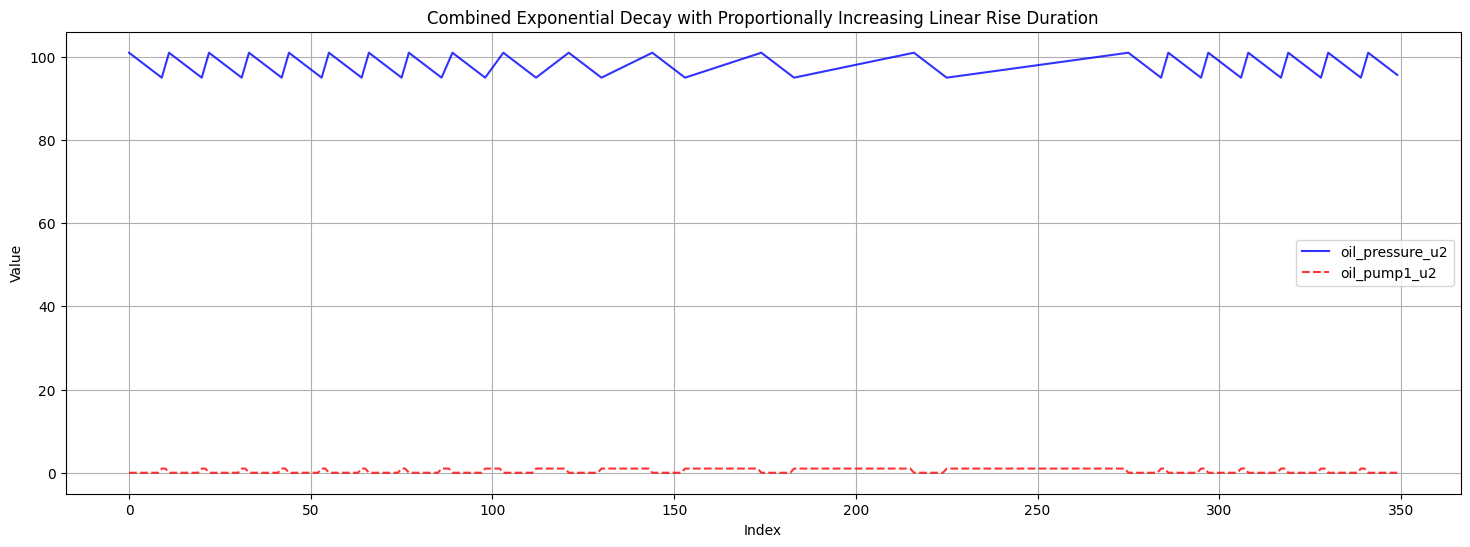

In [21]:
# Generate the final combined data with increasing durations of line_rise proportionally
repetitions = 8
initial_recurrence = 6
end_recurrence = initial_recurrence
# rise_points = 4
# decay_points = 8
# max = 144
# min = 130

rise_points = 3
decay_points = 10
max = 101
min = 95

pump_failure = generate_data_with_slower_increase(max, min, rise_points, decay_points, initial_recurrence, end_recurrence, repetitions, growth_factor=1.5)

# Plotting the final combined data
plt.figure(figsize=(18, 6))
plt.plot(pump_failure.index, pump_failure['oil_pressure_u2'], label='oil_pressure_u2', color='b', alpha=0.8)
plt.plot(pump_failure.index, pump_failure['oil_pump_u2'], label='oil_pump1_u2', color='r', linestyle='--', alpha=0.8)

plt.title('Combined Exponential Decay with Proportionally Increasing Linear Rise Duration')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


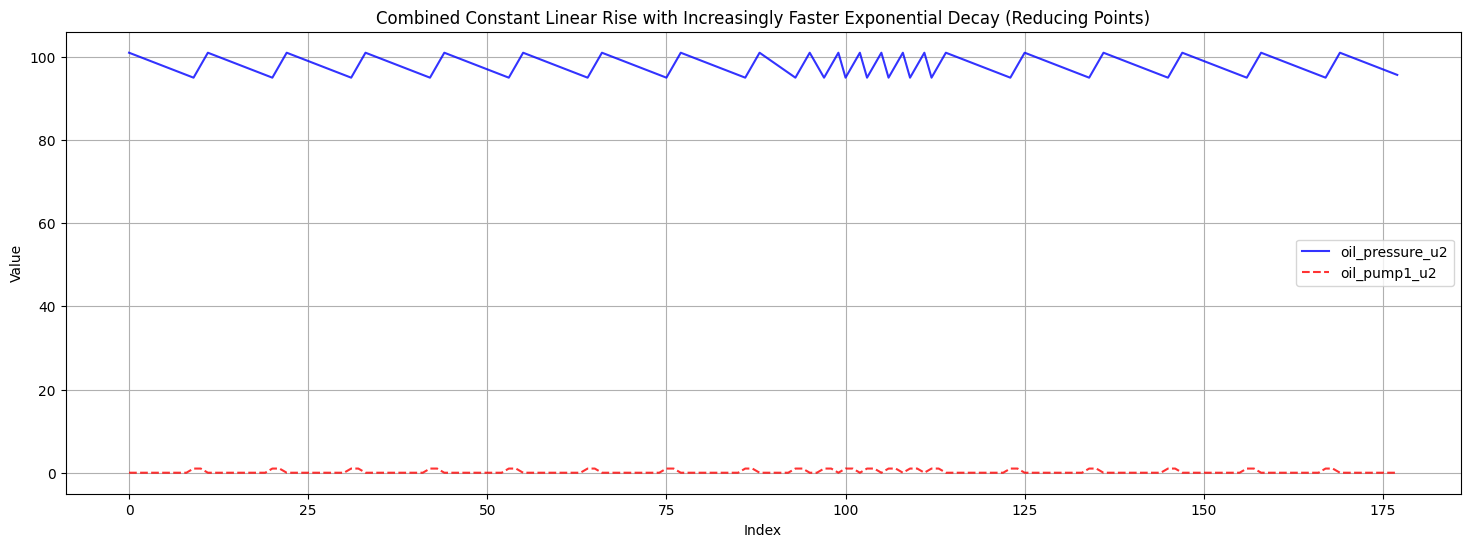

In [22]:
# Generate the final combined data with increasingly faster exponential decays
inter_leakage = generate_combined_data_with_faster_decay(rise_points, decay_points, initial_recurrence, end_recurrence,  repetitions, decay_factor=0.6)

# Plotting the final combined data with increasingly faster decays
plt.figure(figsize=(18, 6))
plt.plot(inter_leakage.index, inter_leakage['oil_pressure_u2'], label='oil_pressure_u2', color='b', alpha=0.8)
plt.plot(inter_leakage.index, inter_leakage['oil_pump_u2'], label='oil_pump1_u2', color='r', linestyle='--', alpha=0.8)

plt.title('Combined Constant Linear Rise with Increasingly Faster Exponential Decay (Reducing Points)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def add_timestamp(data):
    data.index = pd.date_range(start='2024-04-01 00:00:00', periods=len(data), freq='1T')
    data['active_power_u2'] = np.zeros(len(data))
    data = data.iloc[:,[2,0,1]]
    data.index.name = 'timestamp'
    return data

pump_failure = add_timestamp(pump_failure)
pump_failure

/tmp/ipykernel_2699610/1055522715.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data.index = pd.date_range(start='2024-04-01 00:00:00', periods=len(data), freq='1T')


,active_power_u2,oil_pressure_u2,oil_pump_u2
timestamp,,,
2024-04-01 00:00:00,0.0,101.000000,0.0
2024-04-01 00:01:00,0.0,100.333333,0.0
2024-04-01 00:02:00,0.0,99.666667,0.0
2024-04-01 00:03:00,0.0,99.000000,0.0
2024-04-01 00:04:00,0.0,98.333333,0.0
...,...,...,...
2024-04-01 05:45:00,0.0,98.333333,0.0
2024-04-01 05:46:00,0.0,97.666667,0.0
2024-04-01 05:47:00,0.0,97.000000,0.0


In [24]:
inter_leakage = add_timestamp(inter_leakage)
inter_leakage

/tmp/ipykernel_2699610/1055522715.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data.index = pd.date_range(start='2024-04-01 00:00:00', periods=len(data), freq='1T')


,active_power_u2,oil_pressure_u2,oil_pump_u2
timestamp,,,
2024-04-01 00:00:00,0.0,101.000000,0.0
2024-04-01 00:01:00,0.0,100.333333,0.0
2024-04-01 00:02:00,0.0,99.666667,0.0
2024-04-01 00:03:00,0.0,99.000000,0.0
2024-04-01 00:04:00,0.0,98.333333,0.0
...,...,...,...
2024-04-01 02:53:00,0.0,98.333333,0.0
2024-04-01 02:54:00,0.0,97.666667,0.0
2024-04-01 02:55:00,0.0,97.000000,0.0


2024-04-01 01:26:00


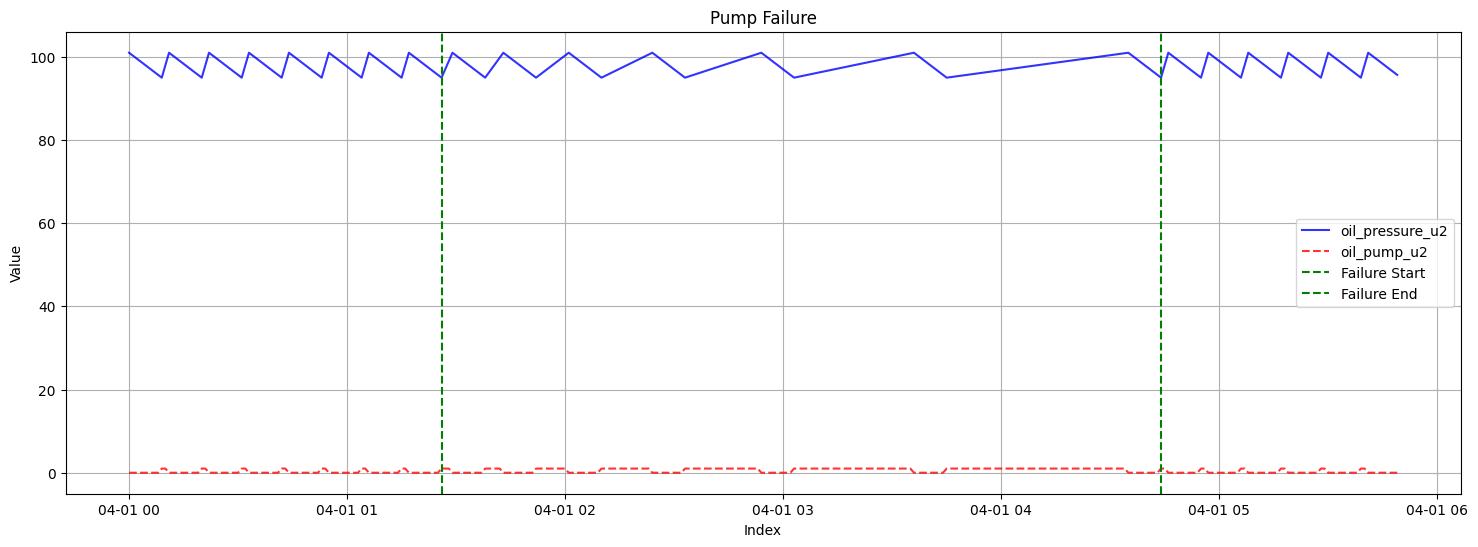

In [ ]:
def identify_fault_label(data, title):
    # Identify positions where 'oil_pump1_u2' changes from 0 to 1
    change_positions = (data['oil_pump_u2'].shift(1) == 0) & (data['oil_pump_u2'] == 1)
    # Find the index of the occurrence
    change_index = change_positions[change_positions].index[initial_recurrence+1]
    if len(change_positions[change_positions]) <= initial_recurrence+repetitions:
        recover_index = data.index[-1]
    else:
        recover_index = change_positions[change_positions].index[initial_recurrence+repetitions]

    # Display the index
    print(change_index)
    plt.figure(figsize=(18, 6))
    plt.plot(data.index, data['oil_pressure_u2'], label='oil_pressure_u2', color='b', alpha=0.8)
    plt.plot(data.index, data['oil_pump_u2'], label='oil_pump_u2', color='r', linestyle='--', alpha=0.8)

    # Mark the fifth change index
    plt.axvline(x=change_index, color='g', linestyle='--', label='Failure Start')
    plt.axvline(x=recover_index, color='g', linestyle='--', label='Failure End')

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    return [str(change_index), str(recover_index)]

labels['pump_failure.csv'] = [identify_fault_label(pump_failure, title='Pump Failure')]
pump_failure.to_csv('./data/test/pump_failure.csv')

2024-04-01 01:26:00


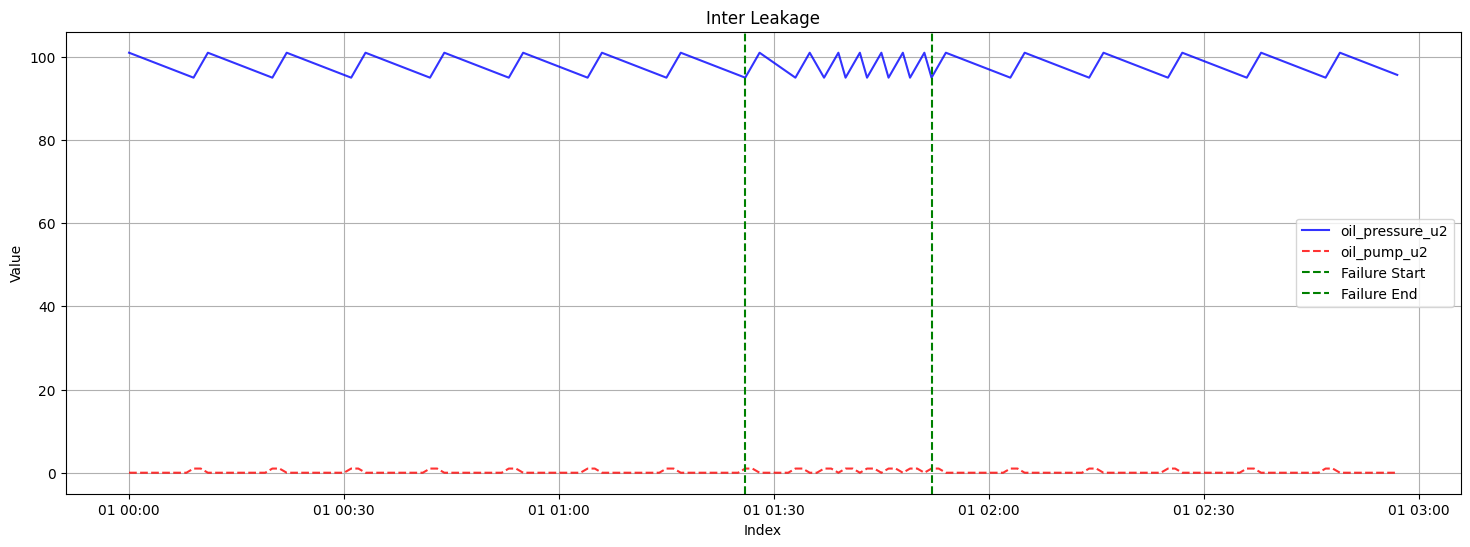

In [ ]:
labels['inter_leakage.csv'] = [identify_fault_label(inter_leakage, title='Inter Leakage')]
inter_leakage.to_csv('./data/test/inter_leakage.csv')

In [27]:
labels

{'pump_failure.csv': [['2024-04-01 01:26:00', '2024-04-01 04:44:00']],
 'inter_leakage.csv': [['2024-04-01 01:26:00', '2024-04-01 01:52:00']]}

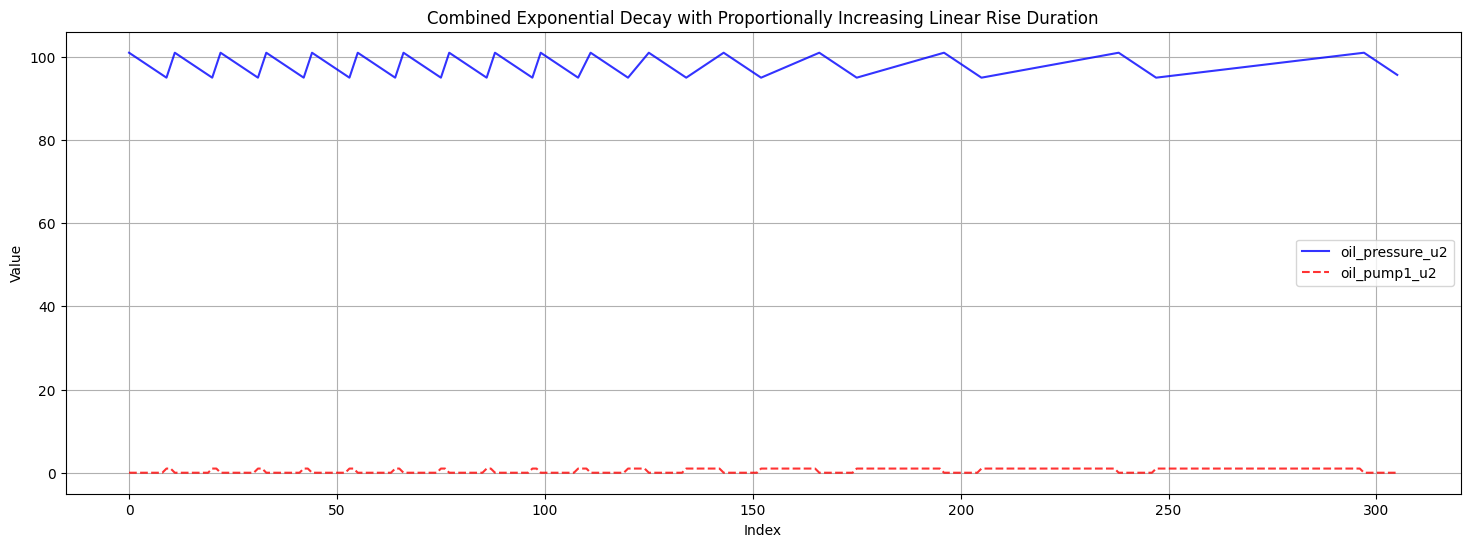

2024-04-01 01:48:00


/tmp/ipykernel_2699610/1055522715.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data.index = pd.date_range(start='2024-04-01 00:00:00', periods=len(data), freq='1T')


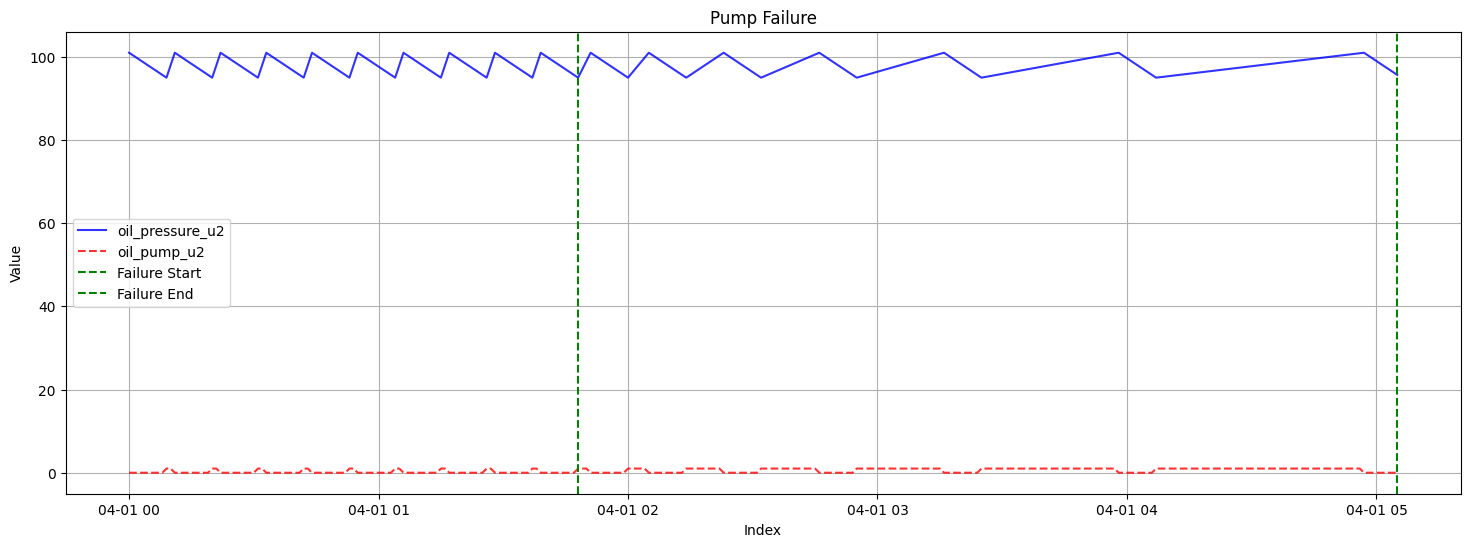

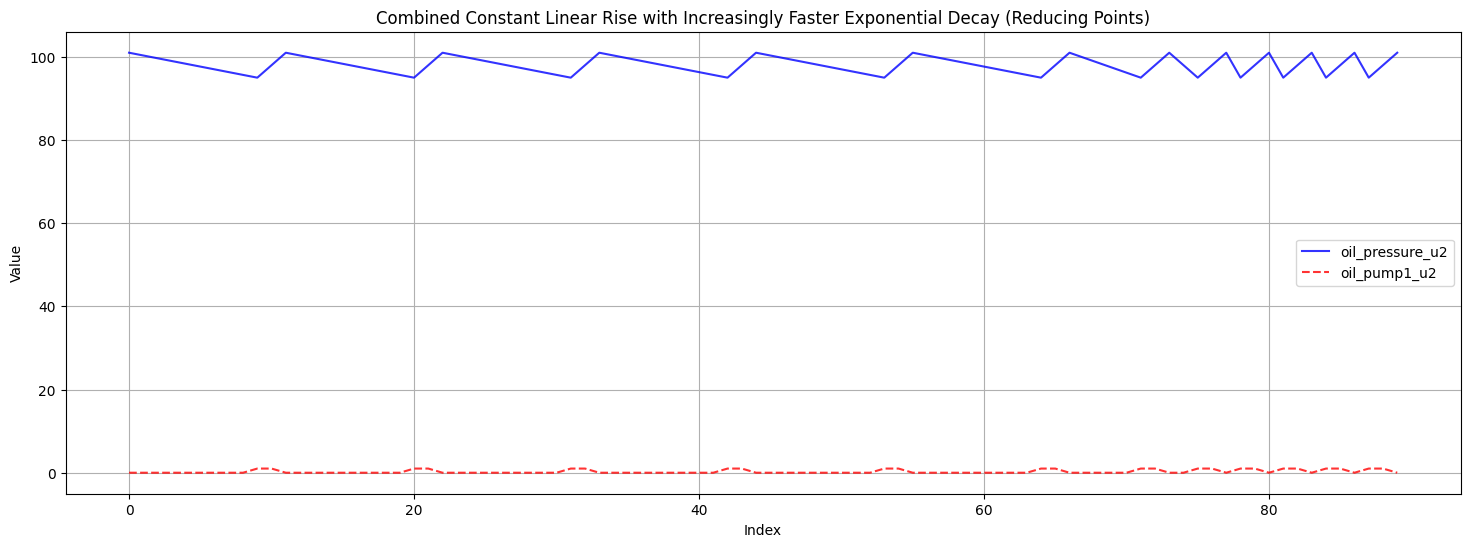

2024-04-01 01:04:00


/tmp/ipykernel_2699610/1055522715.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data.index = pd.date_range(start='2024-04-01 00:00:00', periods=len(data), freq='1T')


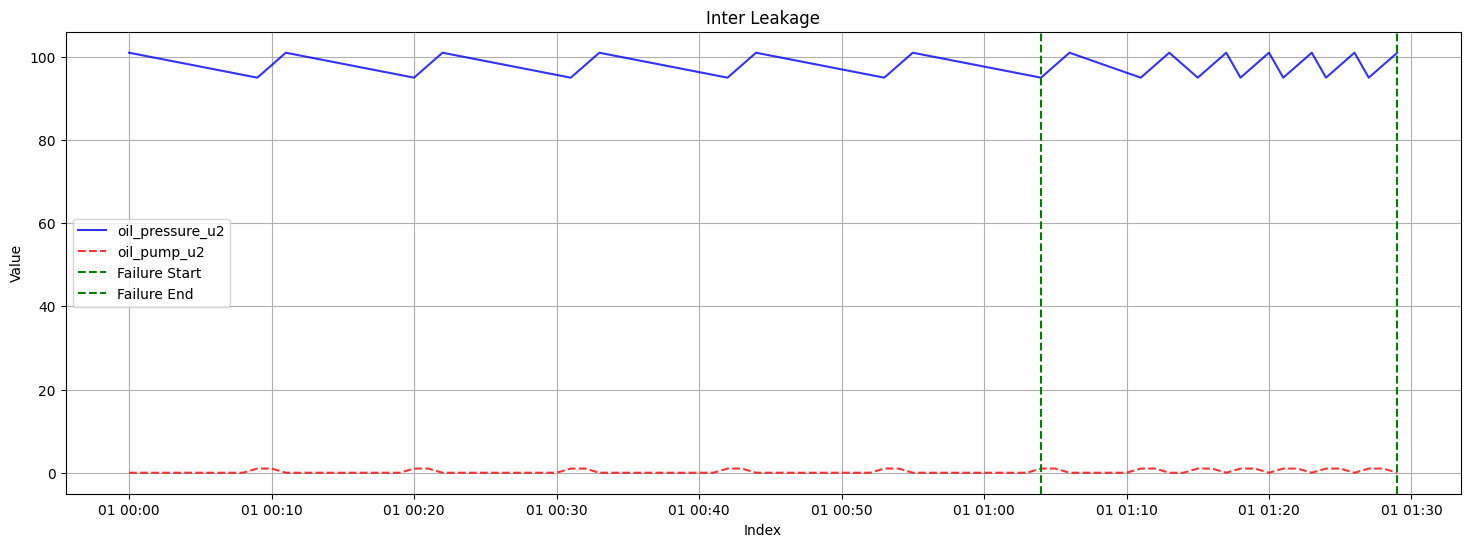

In [ ]:
# Generate the final combined data with increasing durations of line_rise proportionally
repetitions = 8
initial_recurrence = 8
end_recurrence = 0

rise_points = 3
decay_points = 10
max = 101
min = 95

pump_failure = generate_data_with_slower_increase(max, min, rise_points, decay_points, initial_recurrence, end_recurrence,  repetitions, growth_factor=1.5)

# Plotting the final combined data
plt.figure(figsize=(18, 6))
plt.plot(pump_failure.index, pump_failure['oil_pressure_u2'], label='oil_pressure_u2', color='b', alpha=0.8)
plt.plot(pump_failure.index, pump_failure['oil_pump_u2'], label='oil_pump1_u2', color='r', linestyle='--', alpha=0.8)

plt.title('Combined Exponential Decay with Proportionally Increasing Linear Rise Duration')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

pump_failure = add_timestamp(pump_failure)
labels['pump_failure2.csv'] = [identify_fault_label(pump_failure, title='Pump Failure')]
pump_failure.to_csv('./data/test/pump_failure2.csv')


initial_recurrence = 4
# Generate the final combined data with increasingly faster exponential decays
inter_leakage = generate_combined_data_with_faster_decay(rise_points, decay_points, initial_recurrence, end_recurrence,  repetitions, decay_factor=0.6)

# Plotting the final combined data with increasingly faster decays
plt.figure(figsize=(18, 6))
plt.plot(inter_leakage.index, inter_leakage['oil_pressure_u2'], label='oil_pressure_u2', color='b', alpha=0.8)
plt.plot(inter_leakage.index, inter_leakage['oil_pump_u2'], label='oil_pump1_u2', color='r', linestyle='--', alpha=0.8)

plt.title('Combined Constant Linear Rise with Increasingly Faster Exponential Decay (Reducing Points)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

inter_leakage = add_timestamp(inter_leakage)
labels['inter_leakage2.csv'] = [identify_fault_label(inter_leakage, title='Inter Leakage')]
inter_leakage.to_csv('./data/test/inter_leakage2.csv')

In [29]:
with open("./data/labels_window.json", "w") as f:
    json.dump(labels, f, indent=4)



In [30]:
len(pump_failure)

306